In [45]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

### Optimal graph search for small basic model

We will set up a trangle mesh network with a hexagon shape to reprsent the leaf, and find some local minimum tree network structures. The search will start from a uniform (later randomized) edge capacity, and update under the relaxation procedure described in our write up. There is no stochasticity in the search algorithm yet.

Basically, we start with randomized capacity sets. By Kirchhoff's Current Law, we can solve for the potential at each node with the graph Laplacian, and thus calculate the flows. Then using the scaling relationship between capacity and flow that must be satisfied by the optimum solution, we update to get a new set of capacities that are closer to the local minimum solution.

In [2]:
mesh = nx.triangular_lattice_graph(6, 12)

In [3]:
def plot_mesh(mesh):
    node_positions = {}
        
    for node in mesh.nodes:
        node_positions[node] = mesh.nodes[node]['pos']


    fig, ax = plt.subplots(figsize=(8,7))

    nx.draw(mesh, 
            with_labels = True,
            pos=node_positions, 
            node_size= 20,  
            ax = ax) 

    plt.tight_layout()
    plt.show()   

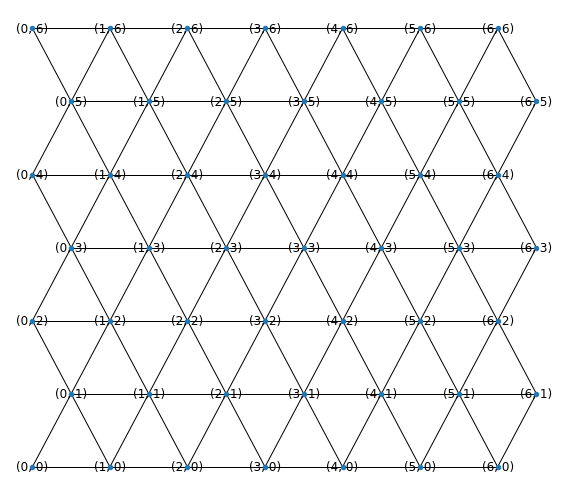

In [4]:
plot_mesh(mesh)

ummm this is not what we want lol; let's make our own then...

In [5]:
def hexagon_leaf(N):
    
    G = nx.generators.triangular_lattice_graph(N,2*N)
    
    for i in range(0,int(N/2)-1):
        G.remove_nodes_from([(i,N/2-2*i-1),(i,N/2-2*i-2)])
        G.remove_nodes_from([(i,N/2+2*i+1),(i,N/2+2*i+2)])
    for j in range(0,int(N/2)-2):
        G.remove_nodes_from([(N-j,N/2-2*j-2),(N-j,N/2-2*j-3)])
        G.remove_nodes_from([(N-j,N/2+2*j+2),(N-j,N/2+2*j+3)])
    # keep the largest component:
    main_comp = np.max([len(comp) for comp in list(nx.connected_components(G))])
    for comp in list(nx.connected_components(G)):
        if len(comp)!=main_comp:
            G.remove_nodes_from(comp)
            
    return G

In [6]:
G = hexagon_leaf(6)

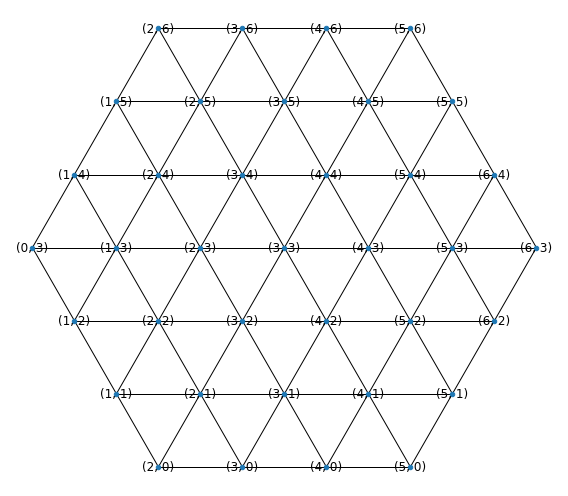

In [7]:
plot_mesh(G)

### Set up the flow transportation network:

In [8]:
K = 1
gamma = 0.5 

def parameterize_leaf(N):
    
    'add transport netowrk variables'

    G = nx.generators.triangular_lattice_graph(N,2*N)
    
    for i in range(0,int(N/2)-1):
        G.remove_nodes_from([(i,N/2-2*i-1),(i,N/2-2*i-2)])
        G.remove_nodes_from([(i,N/2+2*i+1),(i,N/2+2*i+2)])
    for j in range(0,int(N/2)-2):
        G.remove_nodes_from([(N-j,N/2-2*j-2),(N-j,N/2-2*j-3)])
        G.remove_nodes_from([(N-j,N/2+2*j+2),(N-j,N/2+2*j+3)])
    # keep the largest component:
    main_comp = np.max([len(comp) for comp in list(nx.connected_components(G))])
    for comp in list(nx.connected_components(G)):
        if len(comp)!=main_comp:
            G.remove_nodes_from(comp)

    # add edge attr:
    nx.set_node_attributes(G, -1, 'P') # set node strength
    G.nodes[(0,3)]['P'] = G.number_of_nodes() - 1 # set supply node strength
    nx.set_node_attributes(G, 0, 'theta') # initialize potentials, not important, will be the first thing to calculate
    nx.set_node_attributes(G, 'C0', 'color')

    # add node attr:
    nx.set_edge_attributes(G, 1/(G.number_of_nodes()**(1/gamma)), 'weight') # set initial capacity dist. to be uniform, use 'weight' instead of 'k' for easy access of laplacian matrix
    nx.set_edge_attributes(G, 0, 'F') # let's assume that flow is always a positive number here


    return G

In [9]:
def parameterize_leaf_with_hydathode(N, strength = 2, hydathode = (2,1)):

    'add one node as hydathode that is a stronger sink, we keep the supply consistant'
    
    G = nx.generators.triangular_lattice_graph(N,2*N)
    
    for i in range(0,int(N/2)-1):
        G.remove_nodes_from([(i,N/2-2*i-1),(i,N/2-2*i-2)])
        G.remove_nodes_from([(i,N/2+2*i+1),(i,N/2+2*i+2)])
    for j in range(0,int(N/2)-2):
        G.remove_nodes_from([(N-j,N/2-2*j-2),(N-j,N/2-2*j-3)])
        G.remove_nodes_from([(N-j,N/2+2*j+2),(N-j,N/2+2*j+3)])
    # keep the largest component:
    main_comp = np.max([len(comp) for comp in list(nx.connected_components(G))])
    for comp in list(nx.connected_components(G)):
        if len(comp)!=main_comp:
            G.remove_nodes_from(comp)

    # add edge attr, renormalize sinks: 
    re_norm = (G.number_of_nodes() - 1)/(G.number_of_nodes() - 2 + strength) 
    nx.set_node_attributes(G, -1*re_norm, 'P') # set node strength
    G.nodes[(0,3)]['P'] = G.number_of_nodes() - 1 # keep supply consistent
    G.nodes[hydathode]['P'] = -strength*re_norm
    
    nx.set_node_attributes(G, 0, 'theta')

    nx.set_node_attributes(G, 'C0', 'color')
    G.nodes[hydathode]['color'] = 'C1'

    # add node attr:
    nx.set_edge_attributes(G, 1/(G.number_of_nodes()**(1/gamma)), 'weight') # uniform capacity 
    nx.set_edge_attributes(G, 0, 'F') # let's assume that flow is always a positive number here


    return G

In [10]:
def plot_network(mesh):
    '''
    plot network with edge width proportional to sqrt of capacity, which can be seen as proportional to the diameter
    highlight hydathode color
    '''

    node_positions = {}
        
    for node in mesh.nodes:
        node_positions[node] = mesh.nodes[node]['pos']

    diam_list = [np.sqrt(mesh[u][v]['weight'])*100 for u,v in mesh.edges()]
    
    color_list =[ mesh.nodes[node]['color'] for node in mesh.nodes()]

    fig, ax = plt.subplots(figsize=(8,7))

    nx.draw(mesh, 
            with_labels = True,
            pos=node_positions, 
            node_size= 30,  
            node_color = color_list,
            width=diam_list,
            ax = ax) 

    plt.tight_layout()
    plt.show()   


In [11]:
def randomized_k(G):
    
    'start with a different capacity distribution'

    rand_list = np.random.randint(0,10000, G.number_of_edges())
    norm_list = rand_list/rand_list.sum()
    k_list = norm_list**(1/gamma)
    nx.set_edge_attributes(G, dict(zip(list(G.edges),k_list)), 'weight')

#### Plot the uniformly initialized network:


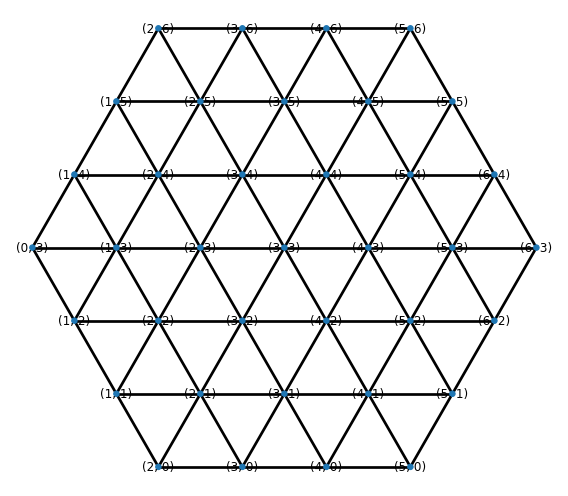

In [12]:
G = parameterize_leaf(6)
plot_network(G)

#### Plot the randomized network:

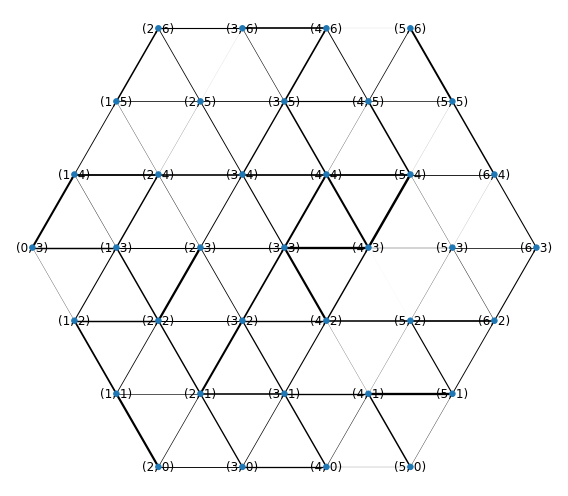

In [13]:
randomized_k(G)
plot_network(G)

### Relaxation functions:

In [14]:
def solve_P_theta(G):
    
    L = nx.laplacian_matrix(G, nodelist=None, weight='weight')
    P_vec = [G.nodes[node]['P'] for node in G.nodes]
    theta_vec = np.linalg.solve(L.todense(), P_vec)
    nx.set_node_attributes(G, dict(zip(list(G.nodes),theta_vec)), 'theta')

    # positive flow: the direction is always toward the node with lower potential: 
    for e in G.edges:
        G[e[0]][e[1]]['F'] =  abs(G[e[0]][e[1]]['weight']*(G.nodes[e[0]]['theta'] - G.nodes[e[1]]['theta']))

In [15]:
# set a threshold to remove the edge: 
weight_lower = 1e-20 

def new_k(G):
    
    F_vec = np.array([G[e[0]][e[1]]['F']  for e in G.edges])
    F_scaling_sum = (((F_vec**2)**(gamma/(1+gamma))).sum())**(1/gamma)

    for e in G.edges:
        weight = (G[e[0]][e[1]]['F']**2)**(1/(1+gamma)) / F_scaling_sum
        if weight < weight_lower:
            G.remove_edge(*e)
        else:
            G[e[0]][e[1]]['weight'] = weight 

    # calculate dissipation:
    weight_vec = np.array([G[e[0]][e[1]]['weight']  for e in G.edges])
    F_vec = np.array([G[e[0]][e[1]]['F']  for e in G.edges]) # need to redefine here, since length might change due to edge drop

    G.graph['D'] = np.dot(F_vec**2, 1/weight_vec)
    
    

#### Run the relaxation for 30 iterations from uniform initialization:¶

In [16]:
G = parameterize_leaf(6)
for i in range(30):
    print('iteration:', i+1)
    solve_P_theta(G)
    new_k(G)
    print('dissipation D:', G.graph['D'])
    print('number of edges left:',G.number_of_edges())
    print()

iteration: 1
dissipation D: 1525178.1835257036
number of edges left: 90

iteration: 2
dissipation D: 1078730.5254739742
number of edges left: 90

iteration: 3
dissipation D: 846849.0307496294
number of edges left: 90

iteration: 4
dissipation D: 799426.6652329685
number of edges left: 90

iteration: 5
dissipation D: 782015.6913418102
number of edges left: 88

iteration: 6
dissipation D: 765796.0387926828
number of edges left: 84

iteration: 7
dissipation D: 747803.7213165266
number of edges left: 78

iteration: 8
dissipation D: 728313.2824907748
number of edges left: 64

iteration: 9
dissipation D: 707843.4595829083
number of edges left: 60

iteration: 10
dissipation D: 686102.7397129982
number of edges left: 60

iteration: 11
dissipation D: 661885.5079397054
number of edges left: 60

iteration: 12
dissipation D: 634320.1321964597
number of edges left: 58

iteration: 13
dissipation D: 604787.1330056915
number of edges left: 54

iteration: 14
dissipation D: 576907.7115772531
number of e

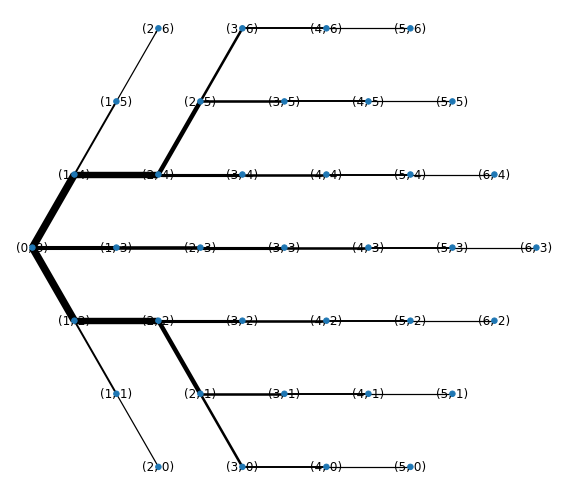

In [17]:
plot_network(G)

It does not look like the most optimized tree, where the biggest conductances are usually on the mid-rib.

#### Run relaxation for network with one bigger sink at node  $(2,1)$ , highlight in orange:

In [18]:
G_h= parameterize_leaf_with_hydathode(6,10)
for i in range(30):
    print('iteration:', i+1)
    solve_P_theta(G_h)
    new_k(G_h)
    print('dissipation D:', G_h.graph['D'])
    print('number of edges left:', G_h.number_of_edges())
    print()

iteration: 1
dissipation D: 1266764.8155386199
number of edges left: 90

iteration: 2
dissipation D: 892487.8432833368
number of edges left: 90

iteration: 3
dissipation D: 728490.6900006504
number of edges left: 90

iteration: 4
dissipation D: 691523.9194090449
number of edges left: 89

iteration: 5
dissipation D: 676615.8495111554
number of edges left: 87

iteration: 6
dissipation D: 664154.2514122415
number of edges left: 84

iteration: 7
dissipation D: 650735.8702920765
number of edges left: 73

iteration: 8
dissipation D: 636038.9637772115
number of edges left: 65

iteration: 9
dissipation D: 619958.9429374085
number of edges left: 60

iteration: 10
dissipation D: 602373.9934851768
number of edges left: 59

iteration: 11
dissipation D: 583673.4844524835
number of edges left: 58

iteration: 12
dissipation D: 564576.8826593453
number of edges left: 57

iteration: 13
dissipation D: 545163.3468947232
number of edges left: 56

iteration: 14
dissipation D: 525130.2919105177
number of ed

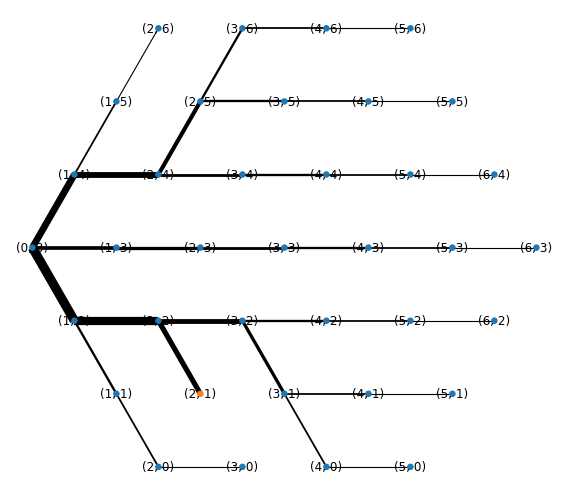

In [19]:
plot_network(G_h)

#### Try initializing with randomized capacities:


In [20]:
G = parameterize_leaf(6)
randomized_k(G)
for i in range(30):
    print('iteration:', i+1)
    solve_P_theta(G)
    new_k(G)
    print('dissipation D:', G.graph['D'])
    print('number of edges left:',G.number_of_edges())

iteration: 1
dissipation D: 1502159.9898702556
number of edges left: 90
iteration: 2
dissipation D: 1097716.1253632181
number of edges left: 90
iteration: 3
dissipation D: 900267.193090975
number of edges left: 90
iteration: 4
dissipation D: 789940.108383568
number of edges left: 89
iteration: 5
dissipation D: 727900.2450600753
number of edges left: 87
iteration: 6
dissipation D: 679046.6878271205
number of edges left: 85
iteration: 7
dissipation D: 632725.202400987
number of edges left: 75
iteration: 8
dissipation D: 603158.5620035318
number of edges left: 65
iteration: 9
dissipation D: 581413.8184296498
number of edges left: 57
iteration: 10
dissipation D: 563670.9102565347
number of edges left: 55
iteration: 11
dissipation D: 558487.3690101765
number of edges left: 50
iteration: 12
dissipation D: 556910.2883461269
number of edges left: 47
iteration: 13
dissipation D: 556341.5505913047
number of edges left: 40
iteration: 14
dissipation D: 556076.8565275951
number of edges left: 40
it

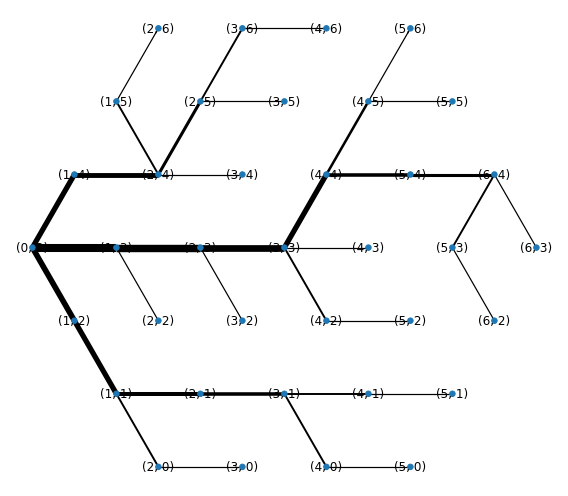

In [21]:
plot_network(G)


It gives us a different tree that also converges.

### Next steps:

- to find better trees: the most simple way might be to search search consequently in the (exponentially large) space of tree topologies using a Monte Carlo algorithm. We can start with some initial tree and then switch links without creating loops and without disconnecting a part of the network. I don't know annealing method a lot but that seems to gaurantee a lower local minimum.

<br/>

- explore in the small network setting how A) location of the hydathode B) strength of the hydathode and C) combination of several hydathode can change the connection of the graph

<br/>

- in the tree network with hydathode, the potential at the hydathode location is actually way _higher_ than average, which is interesting, and also high compared to its neighbors (hasn't plotted yet); this might be something that contradicts hydathode's biology. Then we can think about what constrait is the most reasonable to add on top of this framework.

#### Plot pressure:

In [69]:
def plot_pressure(mesh):
    '''
    plot network with edge width proportional to sqrt of capacity, which can be seen as proportional to the diameter
    highlight hydathode color
    '''
    plt.rcParams['text.usetex'] = True

    node_positions = {}
    node_color = []
    for node in mesh.nodes:
        node_positions[node] = mesh.nodes[node]['pos']
        node_color.append(mesh.nodes[node]['theta'])

    edge_color = []
    for edge in mesh.edges:
        edge_color.append(abs(mesh.nodes[edge[0]]['theta']- mesh.nodes[edge[1]]['theta']))

    fig, ax = plt.subplots(figsize=(8,7))

    nx.draw(mesh, 
            pos=node_positions,       
            node_color = node_color,
            cmap = plt.cm.viridis,
            edge_color =  edge_color,  
            edge_cmap  = plt.cm.Blues,
            node_size= 100,  
            edge_width = 10,
            ax = ax) 

    cbar_ax = fig.add_axes([.2, 0, .6, 0.02])

    cb = mpl.colorbar.ColorbarBase(cbar_ax, orientation='horizontal', 
                                   cmap=plt.cm.viridis,
                                   norm=mpl.colors.Normalize(np.array(node_color).min(), 
                                                             np.array(node_color).max()),
                                   label = 'theta (potential) at each node')
                                   
    plt.show()   

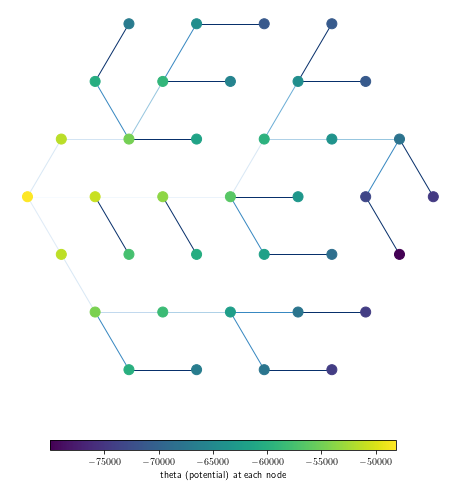

In [70]:
plot_pressure(G)

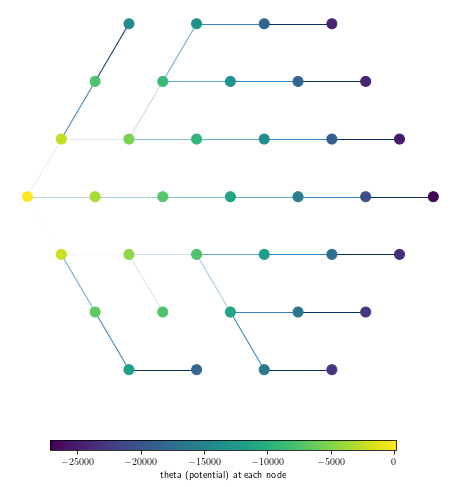

In [71]:
plot_pressure(G_h)

So two things:
- first is that we want to do MC: so pick a random node, set the k to the same as the node before: so there ~ 40 edge to choose from...each time we change the connectivity;
- so the pseudo-code would be:

'''python
when D_t - D_t-1 < eps:
    pick e in exist graph, get k_e
    pick e' in the rest of list, assign k_e to k_e'
    add e'
    remove e
    calculate theta, F, and update k... till  D_t' - D_t'-1 < eps
    if D_t' < D_t:
        accept k_e'? 
        but this might take so long to finally converge? and we might need to keep track of a D_t list.
'''

Okay we'll do it in a new notebook.


- second is how do we deal with the pressure at hydathode

